# Redes Neuronales - Trabajo Práctico N° 2 - Ejercicio 1 - Regresión Logística
# Notebook #2: Implementación de una Regresión Lineal
En esta notebook se busca implementar una regresión logística para poder estimar la condición de diabético de un paciente, perteneciente al Pima Indians Dataset analizado en la notebook anterior.

# TODO List
* Chequear correcto reemplazo de NaN por mean.
* Meter el z-score en scripts comunes a ambos ejercicios. Chequear StandardScaler **correctamente inicializado**. **¿Errores de discretización?**
    * ¿Dónde meto el área bajo la curva ROC y el F2? -> Respondido por Luqui y Karina.
* Añadir **tensorboard** para log entre epochs. Migrar **TODOS LOS GRÁFICOS** a TensorBoard.
    * Agregar evolución de f2-score sobre train en selección del umbral.
* Graficar **learning rate**.
* Sacar los evaluate con **test**, para evitar malas interpretaciones.
* PRIMERA PRUEBA DE POLY (2) ESTÁ MAL! **Falta normalizar despues del poly**
* Informar métricas secundarias
* ¿Kernel/Activity regulariizer? -> **kernel regularizer** afecta a los pesos, **activity regularizer** a las salidas.
* Chequear **Dropout**. Creo que no tendría sentido graficarlo en una sola capa.

# ¿Qué cosas puedo variar?
* Función de activación:
    * Sigmoid
    * RELU
    * ELU
    * tanh
    * Leaky RELU
    
* Optimizador:
    * SGD
    * Adam
    
* Early Stopping: Para el entrenamiento cuando la **loss** deja de mejorar. Se pasa a través de un **callback**. (https://keras.io/api/callbacks/early_stopping/) (https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/)
* Kernel Initializer: Esto es, como son los pesos y bias iniciales. (https://keras.io/api/layers/initializers/)
* Model Checkpoint: Guarda un checkpoint del modelo. Puede configurarse para elegir el mejor. Se pasa por **callback**. (https://keras.io/api/callbacks/model_checkpoint/)
* Scheduling Learning Rate: Se hace variar el **learning rate** con una función. Es un **callback**. (https://keras.io/api/callbacks/learning_rate_scheduler/)
* Reg. dropout: Para evitar overfitting, la capa de dropout "borra" una entrada de forma aleatoria y escala el resto. Es una **capa**. (https://keras.io/api/layers/regularization_layers/dropout/)
* Regularización L1 y L2: Limita el espacio de soluciones agregando un término a la **función de costo**. (https://keras.io/api/layers/regularizers/)
* Data Augmentation
* Batch Normalization: Normaliza las entradas (media=0, dev=1). Es una **capa**. (https://keras.io/api/layers/normalization_layers/batch_normalization/)

# Dudas
* Al generar la métrica F2, ¿me devuelve por batch o por epoch? -> Esto finalmente se explica más adelante.
* Al evaluar el predict en threshold selection ¿batch size?

# ¿Cuáles son los requerimientos para el **clasificador**?
* Métrica principal: **Área bajo la curva ROC**
* Buscar el **umbral de decisión** para maximizar el **f2 score** 
* Informar métricas secundarias:
    * Especificidad - Specificity (True Negative rate) measures the proportion of negatives that are correctly identified (i.e. the proportion of those who do not have the condition (unaffected) who are correctly identified as not having the condition).
    * Sensibilidad
    * Valor predictivo positivo
    * Valor predictivo negativo
    
* **Pregunta adicional**:
Dada la situación en la cual cambia la prevalencia de la enfermedad en la población a ser del 20%. Se desea reutilizar el modelo sin volver a entrenar, ¿Cómo lo harían? ¿Qué métricas se mantienen igual y cuáles cambiarian?. **¿clases desbalanceadas -> class weight?**. Las f-score son buenas para casos no balanceados!

# 1. Cargando base de datos

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
# Read database from .csv
df = pd.read_csv('../../databases/diabetes.csv', delimiter=',')

# Show first rows of data
df.head()
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# 2. Preprocesamiento de los datos

## 2.1 Filtrado de valores inválidos

In [4]:
# Filtering Glucose values
df['Glucose'].replace(0, np.nan, inplace=True)

# Filtering Blood Pressure values
df['BloodPressure'].replace(0, np.nan, inplace=True)

# Filtering Skin Thickness values
df['SkinThickness'].replace(0, np.nan, inplace=True)

# Filtering Insulin values
df['Insulin'].replace(0, np.nan, inplace=True)

# Filtering Body Mass Index values
df['BMI'].replace(0, np.nan, inplace=True)

df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 2.2 Remoción de Outliers

In [5]:
from src.helper import remove_outliers;

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [6]:
x_labels = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction','Age']
y_labels = ['Outcome']

for column in x_labels:
    remove_outliers(df, column)
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,764.000000,763.000000,719.000000,538.000000,370.000000,749.000000,739.000000,759.000000,768.000000
mean,3.786649,121.686763,72.115438,28.903346,132.610811,32.204005,0.429832,32.805007,0.348958
std,3.278714,30.535641,11.239072,9.865480,74.285393,6.491385,0.249684,11.113182,0.476951
min,0.000000,44.000000,40.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,75.000000,27.400000,0.238000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,120.000000,32.000000,0.356000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,177.500000,36.500000,0.587000,40.000000,1.000000
max,13.000000,199.000000,104.000000,56.000000,360.000000,50.000000,1.191000,66.000000,1.000000


# 3. Separación del conjunto de entrenamiento y evaluación

In [7]:
from sklearn import model_selection

In [8]:
from sklearn import preprocessing

In [9]:
# Define input and output variables for the model
df_x = df[x_labels]
df_y = df[y_labels]

In [10]:
# Split the dataset into train_valid and test
x_train_valid, x_test, y_train_valid, y_test = model_selection.train_test_split(df_x, df_y, test_size=0.2, random_state=15, shuffle=True)

# Split the train_valid sub-dataset into train and valid
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train_valid, y_train_valid, test_size=0.3, random_state=10, shuffle=True)

In [11]:
# Train set before NaN replacement
x_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,425.000000,425.000000,403.000000,291.000000,205.000000,417.000000,411.000000,425.000000
mean,3.896471,122.360000,71.665012,28.862543,134.414634,32.166667,0.430713,32.494118
std,3.269876,30.066982,10.805353,9.793471,70.854164,6.341281,0.252835,10.681080
min,0.000000,44.000000,40.000000,8.000000,18.000000,18.200000,0.084000,21.000000
25%,1.000000,100.000000,64.000000,21.500000,76.000000,27.700000,0.235500,24.000000
50%,3.000000,118.000000,72.000000,28.000000,125.000000,31.600000,0.355000,29.000000
75%,6.000000,142.000000,78.000000,36.000000,180.000000,36.300000,0.600500,39.000000
max,13.000000,199.000000,104.000000,52.000000,328.000000,49.600000,1.189000,66.000000


# 4. Reemplazo de valores inválidos
Como se destacó en el análisis estadístico de datos, el dataset suministrado posee varios valores faltantes en algunos individuos. Se asume que en la etapa de producción el modelo contará con todas las variables correctamente informadas, no admitiendo el faltante de alguna de ellas. Luego, se decide reemplazar aquellos valores inválidos en **train**, **valid** y **test** por la correspondiente media en el dataset de train. En este caso, se considera a la media como un estimador correcto para la ocasión.

In [12]:
# Compute the mean of training
train_means = x_train.mean().to_numpy()

# Replacing nan values of the train dataset with training mean values
for index, column in enumerate(x_train.columns):
    x_train.loc[:,column].replace(np.nan, train_means[index], inplace=True)

# Replacing nan values of the test dataset with training mean values
for index, column in enumerate(x_test.columns):
    x_test.loc[:,column].replace(np.nan, train_means[index], inplace=True)
    
# Replacing nan values of the test dataset with training mean values
for index, column in enumerate(x_valid.columns):
    x_valid.loc[:,column].replace(np.nan, train_means[index], inplace=True)

c:\users\joaco\appdata\local\programs\python\python39\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [13]:
# Train set after NaN replacement
x_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,3.896471,122.360000,71.665012,28.862543,134.414634,32.166667,0.430713,32.494118
std,3.254560,29.926152,10.472012,8.061461,48.916861,6.251752,0.247461,10.631051
min,0.000000,44.000000,40.000000,8.000000,18.000000,18.200000,0.084000,21.000000
25%,1.000000,100.000000,64.000000,25.000000,129.000000,27.800000,0.238000,24.000000
50%,3.000000,119.000000,71.665012,28.862543,134.414634,32.000000,0.371000,29.000000
75%,6.000000,141.000000,78.000000,32.000000,134.414634,36.000000,0.591000,39.000000
max,13.000000,199.000000,104.000000,52.000000,328.000000,49.600000,1.189000,66.000000


In [14]:
# Validation set after NaN replacement
x_valid.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,3.691892,119.850595,73.313406,28.960620,131.659328,32.292252,0.426025,33.678283
std,3.284878,30.084793,12.045479,8.215413,51.838933,6.738731,0.245125,11.670442
min,0.000000,57.000000,44.000000,7.000000,14.000000,19.600000,0.096000,21.000000
25%,1.000000,99.000000,65.000000,26.000000,116.000000,26.600000,0.241000,24.000000
50%,3.000000,114.000000,72.000000,28.862543,134.414634,32.500000,0.365000,30.000000
75%,6.000000,136.000000,82.000000,32.000000,134.414634,36.500000,0.542000,42.000000
max,13.000000,198.000000,100.000000,54.000000,335.000000,50.000000,1.159000,66.000000


In [15]:
# Test set after NaN replacement
x_test.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,3.597403,122.038961,71.787761,28.887267,133.390719,32.197403,0.432119,32.603820
std,3.304818,32.320876,10.448535,8.867500,58.146512,6.484578,0.238998,11.431621
min,0.000000,61.000000,44.000000,7.000000,23.000000,18.400000,0.078000,21.000000
25%,1.000000,95.250000,64.000000,23.250000,108.250000,26.925000,0.254000,24.000000
50%,3.000000,117.000000,71.665012,28.862543,134.414634,32.166667,0.376500,28.000000
75%,5.750000,142.750000,79.500000,33.000000,134.414634,36.625000,0.567000,40.750000
max,13.000000,197.000000,94.000000,56.000000,360.000000,49.300000,1.191000,66.000000


# 5. Normalización de datos de entrada. Z Score. 
Dado que todas las variables en juego son numéricas, se puede aplicar z-score a todo el dataset. Esta operación se hace con el objetivo de poder obtener mayor información de los pesos calculados por el modelo.

In [16]:
# IMPORTANT! Backup unnormalized subsets for further utilization
x_train_un = x_train
x_valid_un = x_valid
x_test_un = x_test

# Apply z-score to all sub-datasets
scalable_variables = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction','Age']

if scalable_variables:
    # Create an instance of the StandardScaler for each variable
    scaler = preprocessing.StandardScaler()

    # Fit the distribution
    scaler.fit(x_train.loc[:, scalable_variables])

    # Transform and normalize all variables
    x_train.loc[:, scalable_variables] = scaler.transform(x_train.loc[:, scalable_variables])
    x_test.loc[:, scalable_variables] = scaler.transform(x_test.loc[:, scalable_variables])
    x_valid.loc[:, scalable_variables] = scaler.transform(x_valid.loc[:, scalable_variables])

c:\users\joaco\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\joaco\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
c:\users\joaco\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

In [17]:
x_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,4.290000e+02,4.290000e+02,4.290000e+02,4.290000e+02,4.290000e+02,4.290000e+02,4.290000e+02,4.290000e+02
mean,-4.140692e-17,2.484415e-17,-3.498885e-16,3.685216e-16,-5.010237e-16,3.457478e-16,1.242208e-16,1.780498e-16
std,1.001168e+00,1.001168e+00,1.001168e+00,1.001168e+00,1.001168e+00,1.001168e+00,1.001168e+00,1.001168e+00
min,-1.198632e+00,-2.621503e+00,-3.027306e+00,-2.590957e+00,-2.382625e+00,-2.236649e+00,-1.402716e+00,-1.082446e+00
25%,-8.910121e-01,-7.480449e-01,-7.328068e-01,-4.796963e-01,-1.108198e-01,-6.992863e-01,-7.796693e-01,-7.999242e-01
50%,-2.757722e-01,-1.124075e-01,0.000000e+00,4.412180e-16,-5.816991e-16,-2.669032e-02,-2.415838e-01,-3.290547e-01
75%,6.470876e-01,6.235938e-01,6.056510e-01,3.896465e-01,-5.816991e-16,6.138773e-01,6.484824e-01,6.126843e-01
max,2.800427e+00,2.563961e+00,3.091358e+00,2.873483e+00,3.962057e+00,2.791807e+00,3.067844e+00,3.155380e+00


# 6. Regresión Logística - Test #1
Primera prueba de regresión logística. Se usa SGD y AUC como métrica principal. Se emplea la Binary Cross-Entropy como loss subrogada, dado que **la AUC no es diferenciable**.

In [18]:
# Loading TensorBoard for learning logging
%load_ext tensorboard

In [19]:
import tensorflow as tf
import datetime

In [20]:
from keras.models import Sequential, load_model
from keras.layers import Dense, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.metrics import SensitivityAtSpecificity
from keras.callbacks import TensorBoard, ModelCheckpoint

In [21]:
# Define model checkpoint callback
mc_path = 'model_checkpoints/logistic_regression_first_test.h5'
mc_callback = ModelCheckpoint(filepath=mc_path, monitor='val_auc', save_best_only=True, mode='max')

In [22]:
# Sequential model
model = Sequential()
model.add(Dense(1, input_shape=(8,), activation='sigmoid', use_bias=True))

# Get model brief
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Metrics definition
metrics = ['AUC', 'accuracy']

In [24]:
# Compiling model
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=metrics)
# Configuring TensorBoard to log learning process
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
# Training model
model.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), shuffle=True, epochs=200, batch_size=32, verbose=1, callbacks=[tensorboard_callback, mc_callback])

Epoch 1/200
14/14 [==============================] - 13s 123ms/step - loss: 0.8785 - auc: 0.5681 - accuracy: 0.5684 - val_loss: 0.8949 - val_auc: 0.5970 - val_accuracy: 0.5784
Epoch 2/200
14/14 [==============================] - 0s 7ms/step - loss: 0.8606 - auc: 0.5893 - accuracy: 0.5628 - val_loss: 0.8752 - val_auc: 0.6055 - val_accuracy: 0.5892
Epoch 3/200
14/14 [==============================] - 0s 7ms/step - loss: 0.7887 - auc: 0.6223 - accuracy: 0.6106 - val_loss: 0.8564 - val_auc: 0.6161 - val_accuracy: 0.6000
Epoch 4/200
14/14 [==============================] - 0s 6ms/step - loss: 0.7441 - auc: 0.6727 - accuracy: 0.6515 - val_loss: 0.8387 - val_auc: 0.6256 - val_accuracy: 0.6162
Epoch 5/200
14/14 [==============================] - 0s 7ms/step - loss: 0.8126 - auc: 0.6046 - accuracy: 0.5809 - val_loss: 0.8231 - val_auc: 0.6347 - val_accuracy: 0.6216
Epoch 6/200
14/14 [==============================] - 0s 7ms/step - loss: 0.7820 - auc: 0.6420 - accuracy: 0.6163 - val_loss: 0.8079 

In [25]:
# TensorBoard launch
%tensorboard --logdir logs/fit

In [26]:
model = load_model(mc_path)
eval = model.evaluate(x=x_test, y=y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.5033 - auc: 0.8018 - accuracy: 0.7143


# 7. Elección del umbral usando f2 score

A la prueba anterior, se suma la selección del umbral (o **threshold**) con el cual el clasificador discrimina entre clases. El mejor umbral de clasificación se calcula para todos los modelos, después del correspondiente entrenamiento. Para esta elección se elije el mejor valor del f2-score sobre el subset de **valid**. También se muestra la evolución de esta métrica respecto al umbral en el subset de **train**. En teoría, este umbral **no modifica la mérica principal del modelo, que es el área bajo la curva ROC**.

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score

def round_threshold(vector, threshold=0.5):
    rounded_vector = []
    for element in vector:
        if element >= threshold:
            rounded_vector.append(1)
        else:
            rounded_vector.append(0)
            
    return np.array(rounded_vector)
        
def f2_threshold_selection(y_probs_valid, y_true_valid, y_probs_train, y_true_train, steps=100, plot=True):
    # Thresholds and f2-score vectors
    thresholds = np.linspace(0, 1, steps)
    f2_score_valid = []
    f2_score_train = []
    
    for thld in thresholds:
        # Generate predictions with current threshold
        y_pred_valid = round_threshold(vector=y_probs_valid, threshold=thld)
        y_pred_train = round_threshold(vector=y_probs_train, threshold=thld)
        # Compute f2 score for that threshold and append
        score_valid = fbeta_score(y_true=y_true_valid, y_pred=y_pred_valid, beta=2)
        score_train = fbeta_score(y_true=y_true_train, y_pred=y_pred_train, beta=2)
        f2_score_valid.append(score_valid)
        f2_score_train.append(score_train)
    
    idx = np.argmax(f2_score_valid)
    if plot == True:
        plt.plot(thresholds, f2_score_valid, label='valid')
        plt.plot(thresholds, f2_score_train, label='train')
        plt.xlabel('Threshold')
        plt.ylabel('F2 score')
        plt.axvline(thresholds[idx], color='black', linestyle='--')
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.grid(b=True)
        plt.title('Selecting best threshold')
        plt.legend()
        plt.show()
        
    return thresholds, f2_score_valid, idx
    

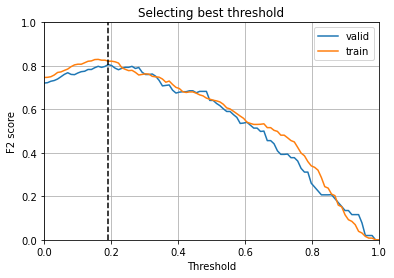

Best f2-score for valid is 0.8060 @ threshold = 0.1919


In [28]:
# Get binary-class probability from model
y_probs_valid = model.predict(x_valid)
y_probs_train = model.predict(x_train)
thresholds, f2_score, idx = f2_threshold_selection(y_probs_valid, y_valid, y_probs_train, y_train, steps=100)
print(f'Best f2-score for valid is {f2_score[idx]:.4f} @ threshold = {thresholds[idx]:.4f}')

# 8. Early Stopping
Habiendo concluido el test #1, se cree necesario agregar un callback de early stopping al modelo. Este callback deberá detener el proceso de aprendizaje en el momento en el que la **métrica principal** del modelo **deje de aumentar**. Posteriormente, se recupera el modelo con mejor performance en cuanto a esta métrica (AUC). Cabe aclarar que esta técnica es especialmente útil cuando la métrica principal no es diferenciable, y por ende se debe emplear una **loss subrogada** (en este caso, la binary cross entropy). De esta forma, el número de epochs que recorra el proceso de entrenamiento se verá limitada.

In [29]:
# Import Early Stopping callback from keras.
from keras.callbacks import EarlyStopping

In [30]:
# Configure Early Stopping callback
es_callback = EarlyStopping(monitor='val_auc', mode='max', min_delta=0.001, patience=10, restore_best_weights=True)

# Define Model Checkpoint callback
mc_path = 'model_checkpoints/early_stopping_test.h5'
mc_callback = ModelCheckpoint(filepath=mc_path, monitor='val_auc', save_best_only=True, mode='max')

# Creating new model
es_model = Sequential()
es_model.add(Dense(1, input_shape=(8,), activation='sigmoid', use_bias=True))

# Compiling model
es_model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=metrics)

# Configuring TensorBoard to log learning process
log_dir = "logs/fit/ES/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Training model
es_model.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), shuffle=True, epochs=1000, batch_size=32, verbose=1, callbacks=[tensorboard_callback, es_callback, mc_callback])

Epoch 1/1000
14/14 [==============================] - 3s 170ms/step - loss: 0.9652 - auc: 0.3580 - accuracy: 0.4266 - val_loss: 1.0442 - val_auc: 0.3422 - val_accuracy: 0.4054
Epoch 2/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.9799 - auc: 0.3580 - accuracy: 0.4377 - val_loss: 1.0068 - val_auc: 0.3606 - val_accuracy: 0.4162
Epoch 3/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.8949 - auc: 0.4075 - accuracy: 0.4751 - val_loss: 0.9726 - val_auc: 0.3798 - val_accuracy: 0.4486
Epoch 4/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.9193 - auc: 0.3522 - accuracy: 0.4210 - val_loss: 0.9418 - val_auc: 0.4012 - val_accuracy: 0.4541
Epoch 5/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.8361 - auc: 0.4585 - accuracy: 0.4978 - val_loss: 0.9134 - val_auc: 0.4212 - val_accuracy: 0.4649
Epoch 6/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.8435 - auc: 0.4304 - accuracy: 0.4716 - val_loss: 0.

In [31]:
# Evaluate test subset and predict.
es_model = load_model(mc_path)
eval = es_model.evaluate(x=x_test, y=y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.4993 - auc: 0.8121 - accuracy: 0.7403


# 9. Learning Rate Scheduling
En este apartado se prueba la opción de Learning Rate Scheduling. Esta se encarga de aplicarle una función al Learning Rate entre epochs, de forma tal de encontrar el mínimo de la loss de forma más rápida, y apuntando a evitar mínimos locales y, por ende, overfitting. Se sigue aplicando el concepto de **early stopping** para la AUC. 

In [32]:
from keras.optimizers import SGD, Adam
from keras.optimizers.schedules import ExponentialDecay, PolynomialDecay # API in https://keras.io/api/optimizers/learning_rate_schedules/

In [33]:
# Define model checkpoint callback
mc_path = 'model_checkpoints/lrs_test.h5'
mc_callback = ModelCheckpoint(filepath=mc_path, monitor='val_auc', save_best_only=True, mode='max')

# Configuring TensorBoard to log learning process
log_dir = "logs/fit/LRS/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Creating new model
lrs_model = Sequential()
lrs_model.add(Dense(1, input_shape=(8,), activation='sigmoid', use_bias=True))

# Define learning rate at start
ilr = 0.1
lr_schedule = ExponentialDecay(ilr, decay_steps=100000, decay_rate=0.96, staircase=False) # Decay every (decay_steps) steps with a base of (decay_rate).

# Compiling model
lrs_model.compile(optimizer=SGD(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=metrics)

# Training model
lrs_model.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), shuffle=True, epochs=200, batch_size=32, verbose='auto', callbacks=[tensorboard_callback, es_callback, mc_callback])

Epoch 1/200
14/14 [==============================] - 3s 158ms/step - loss: 0.7020 - auc: 0.7329 - accuracy: 0.6629 - val_loss: 0.6186 - val_auc: 0.7535 - val_accuracy: 0.7027
Epoch 2/200
14/14 [==============================] - 0s 3ms/step - loss: 0.5773 - auc: 0.7817 - accuracy: 0.6986 - val_loss: 0.5725 - val_auc: 0.7789 - val_accuracy: 0.7243
Epoch 3/200
14/14 [==============================] - 0s 3ms/step - loss: 0.5181 - auc: 0.8200 - accuracy: 0.7292 - val_loss: 0.5440 - val_auc: 0.7937 - val_accuracy: 0.7405
Epoch 4/200
14/14 [==============================] - 0s 3ms/step - loss: 0.5269 - auc: 0.8164 - accuracy: 0.7419 - val_loss: 0.5260 - val_auc: 0.8019 - val_accuracy: 0.7351
Epoch 5/200
14/14 [==============================] - 0s 3ms/step - loss: 0.5145 - auc: 0.8163 - accuracy: 0.7352 - val_loss: 0.5120 - val_auc: 0.8093 - val_accuracy: 0.7405
Epoch 6/200
14/14 [==============================] - 0s 3ms/step - loss: 0.5176 - auc: 0.8145 - accuracy: 0.7541 - val_loss: 0.5025 -

In [34]:
# Evaluate model with test subset.
lrs_model = load_model(mc_path)
eval = lrs_model.evaluate(x=x_test, y=y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.5041 - auc: 0.8066 - accuracy: 0.7403


**PREGUNTA**: ¿Exponential Decay se lleva bien con Early Stopping?, ya que si reduzco el learning rate "me muevo menos", con lo cual el callback de Early Stopping cortaría prematuramente. Ahora probamos sin Early Stopping.

In [35]:
# Configuring TensorBoard to log learning process
log_dir = "logs/fit/LRS/noES" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Training model
lrs_model.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), shuffle=True, epochs=200, batch_size=32, verbose='auto', callbacks=[tensorboard_callback, mc_callback])

Epoch 1/200
14/14 [==============================] - 2s 118ms/step - loss: 0.4609 - auc: 0.8495 - accuracy: 0.7786 - val_loss: 0.4778 - val_auc: 0.8372 - val_accuracy: 0.7784
Epoch 2/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4610 - auc: 0.8497 - accuracy: 0.7762 - val_loss: 0.4774 - val_auc: 0.8379 - val_accuracy: 0.7784
Epoch 3/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4610 - auc: 0.8493 - accuracy: 0.7762 - val_loss: 0.4771 - val_auc: 0.8380 - val_accuracy: 0.7730
Epoch 4/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4614 - auc: 0.8490 - accuracy: 0.7762 - val_loss: 0.4772 - val_auc: 0.8374 - val_accuracy: 0.7730
Epoch 5/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4610 - auc: 0.8488 - accuracy: 0.7809 - val_loss: 0.4765 - val_auc: 0.8377 - val_accuracy: 0.7676
Epoch 6/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4613 - auc: 0.8491 - accuracy: 0.7832 - val_loss: 0.4758 -

In [36]:
# Evaluate model with test subset.
lrs_model = load_model(mc_path)
eval = lrs_model.evaluate(x=x_test, y=y_test)

5/5 [==============================] - 0s 1ms/step - loss: 0.5037 - auc: 0.8039 - accuracy: 0.7403


# 10. Regularización
La idea de la regularización es la de limitar aquellos pesos que son altos. De esta forma, se agrega una capa previa a la capa densa que contiene la capa de regularización. Se probarán dos regularizaciones distintas: L1 y L2 (donde el número significa el grado del término adicional que se suma a la función de costo).

# 10.1. Regularización L1

In [37]:
from keras.regularizers import l1, l2, l1_l2

In [60]:
# Define model checkpoint callback
mc_path = 'model_checkpoints/L1_test.h5'
mc_callback = ModelCheckpoint(filepath=mc_path, monitor='val_auc', save_best_only=True, mode='max')

# Configuring TensorBoard to log learning process
log_dir = "logs/fit/REG/L1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Creating new model for L1 Regularization
l1_model = Sequential()

# Adding dense layer to model
l1_model.add(Dense(1, input_shape=(8,), activation='sigmoid', use_bias=True, kernel_regularizer=l1(1e-3)))

# Compiling model
l1_model.compile(optimizer=SGD(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=metrics)

# Training model
l1_model.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), shuffle=True, epochs=200, batch_size=32, verbose='auto', callbacks=[tensorboard_callback, es_callback, mc_callback])

Epoch 1/200
14/14 [==============================] - 3s 150ms/step - loss: 0.6229 - auc: 0.7084 - accuracy: 0.6594 - val_loss: 0.5521 - val_auc: 0.7929 - val_accuracy: 0.7135
Epoch 2/200
14/14 [==============================] - 0s 3ms/step - loss: 0.5058 - auc: 0.8211 - accuracy: 0.7329 - val_loss: 0.5144 - val_auc: 0.8167 - val_accuracy: 0.7622
Epoch 3/200
14/14 [==============================] - 0s 4ms/step - loss: 0.4939 - auc: 0.8337 - accuracy: 0.7502 - val_loss: 0.4963 - val_auc: 0.8239 - val_accuracy: 0.7568
Epoch 4/200
14/14 [==============================] - 0s 5ms/step - loss: 0.4654 - auc: 0.8564 - accuracy: 0.7843 - val_loss: 0.4851 - val_auc: 0.8342 - val_accuracy: 0.7730
Epoch 5/200
14/14 [==============================] - 0s 5ms/step - loss: 0.4601 - auc: 0.8552 - accuracy: 0.7856 - val_loss: 0.4826 - val_auc: 0.8354 - val_accuracy: 0.7784
Epoch 6/200
14/14 [==============================] - 0s 3ms/step - loss: 0.5063 - auc: 0.8071 - accuracy: 0.7561 - val_loss: 0.4845 -

In [61]:
l1_model = load_model(mc_path)
eval = l1_model.evaluate(x=x_test, y=y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.5074 - auc: 0.8050 - accuracy: 0.7403


# 10.2. Regularización L2

In [64]:
# Define model checkpoint callback
mc_path = 'model_checkpoints/L2_test.h5'
mc_callback = ModelCheckpoint(filepath=mc_path, monitor='val_auc', save_best_only=True, mode='max')

# Configuring TensorBoard to log learning process
log_dir = "logs/fit/REG/L2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Creating new model for L2 Regularization
l2_model = Sequential()
# Adding dense layer to model
l2_model.add(Dense(1, input_shape=(8,), activation='sigmoid', use_bias=True, kernel_regularizer=l2(1e-2)))
# Compiling model
l2_model.compile(optimizer=SGD(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=metrics)
# Training model
l2_model.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), shuffle=True, epochs=200, batch_size=32, verbose='auto', callbacks=[tensorboard_callback, es_callback, mc_callback])


Epoch 1/200
14/14 [==============================] - 3s 152ms/step - loss: 0.7761 - auc: 0.6312 - accuracy: 0.5955 - val_loss: 0.5253 - val_auc: 0.8112 - val_accuracy: 0.7514
Epoch 2/200
14/14 [==============================] - 0s 3ms/step - loss: 0.5527 - auc: 0.7838 - accuracy: 0.7032 - val_loss: 0.4875 - val_auc: 0.8463 - val_accuracy: 0.7838
Epoch 3/200
14/14 [==============================] - 0s 5ms/step - loss: 0.4945 - auc: 0.8390 - accuracy: 0.7576 - val_loss: 0.4831 - val_auc: 0.8496 - val_accuracy: 0.7838
Epoch 4/200
14/14 [==============================] - 0s 4ms/step - loss: 0.4752 - auc: 0.8486 - accuracy: 0.7719 - val_loss: 0.4836 - val_auc: 0.8451 - val_accuracy: 0.7730
Epoch 5/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4559 - auc: 0.8682 - accuracy: 0.8017 - val_loss: 0.4829 - val_auc: 0.8438 - val_accuracy: 0.7892
Epoch 6/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4828 - auc: 0.8457 - accuracy: 0.7527 - val_loss: 0.4842 -

In [65]:
l2_model = load_model(mc_path)
eval = l2_model.evaluate(x=x_test, y=y_test)

5/5 [==============================] - 1s 1ms/step - loss: 0.5329 - auc: 0.8019 - accuracy: 0.7338


# 10.3. Regularización L1+L2

In [42]:
# Define model checkpoint callback
mc_path = 'model_checkpoints/L1+L2_test.h5'
mc_callback = ModelCheckpoint(filepath=mc_path, monitor='val_auc', save_best_only=True, mode='max')

# Configuring TensorBoard to log learning process
log_dir = "logs/fit/REG/L1L2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Creating new model for L1 and L2 Regularization
l1l2_model = Sequential()

# Adding dense layer to model
l1l2_model.add(Dense(1, input_shape=(8,), activation='sigmoid', use_bias=True, kernel_regularizer=l2(0.01)))

# Compiling model
l1l2_model.compile(optimizer=SGD(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=metrics)

# Training model
l1l2_model.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), shuffle=True, epochs=200, batch_size=32, verbose='auto', callbacks=[tensorboard_callback, es_callback, mc_callback])

Epoch 1/200
14/14 [==============================] - 3s 124ms/step - loss: 0.6663 - auc: 0.6594 - accuracy: 0.6342 - val_loss: 0.6167 - val_auc: 0.7239 - val_accuracy: 0.6486
Epoch 2/200
14/14 [==============================] - 0s 3ms/step - loss: 0.5871 - auc: 0.7527 - accuracy: 0.6900 - val_loss: 0.5709 - val_auc: 0.7700 - val_accuracy: 0.7081
Epoch 3/200
14/14 [==============================] - 0s 3ms/step - loss: 0.5380 - auc: 0.8141 - accuracy: 0.7515 - val_loss: 0.5448 - val_auc: 0.7929 - val_accuracy: 0.7027
Epoch 4/200
14/14 [==============================] - 0s 5ms/step - loss: 0.5129 - auc: 0.8231 - accuracy: 0.7404 - val_loss: 0.5300 - val_auc: 0.8049 - val_accuracy: 0.7135
Epoch 5/200
14/14 [==============================] - 0s 3ms/step - loss: 0.5127 - auc: 0.8274 - accuracy: 0.7435 - val_loss: 0.5203 - val_auc: 0.8096 - val_accuracy: 0.7189
Epoch 6/200
14/14 [==============================] - 0s 3ms/step - loss: 0.5048 - auc: 0.8216 - accuracy: 0.7339 - val_loss: 0.5123 -

In [43]:
l1l2_model = load_model(mc_path)
eval = l1l2_model.evaluate(x=x_test, y=y_test)

5/5 [==============================] - 0s 1ms/step - loss: 0.5062 - auc: 0.8090 - accuracy: 0.7403


En este caso, se nota una leve mejora en la métrica empleando regularización L2.

# 11. Dropout
Se emplea una capa extra de dropout para minimizar el overfitting. Este regularizador funciona ignorando a neuronas de forma aleatoria. Se realiza dropout **solo en la etapa de entrenamiento**. **En teoría, no se lleva muy bien con la normalización por capas**. No tiene sentido probar esto en una red de una sola capa oculta.

In [44]:
from keras.layers import Dropout

In [45]:
# Define model checkpoint callback
mc_path = 'model_checkpoints/dropout_test.h5'
mc_callback = ModelCheckpoint(filepath=mc_path, monitor='val_auc', save_best_only=True, mode='max')

# Configuring TensorBoard to log learning process
log_dir = "logs/fit/REG/Dropout/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Creating model
do_model = Sequential()

# Adding dropout layer to network
do_model.add(Dropout(0))

# Adding Dense layer
do_model.add(Dense(1, input_shape=(8,), activation='sigmoid', use_bias=True, activity_regularizer=l2(1e-4)))

# Compiling model
do_model.compile(optimizer=SGD(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=metrics)

# Training model
do_model.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), shuffle=True, epochs=200, batch_size=32, verbose=0, callbacks=[tensorboard_callback, es_callback, mc_callback])
do_model.evaluate(x=x_valid, y=y_valid)

6/6 [==============================] - 0s 2ms/step - loss: 0.4776 - auc: 0.8376 - accuracy: 0.7784


[0.4776472747325897, 0.8375617861747742, 0.7783783674240112]

In [46]:
model = Sequential()
model.add(Dense(1, input_shape=(8,), activation='sigmoid', use_bias=True, activity_regularizer=l2(1e-4)))
model.compile(optimizer=SGD(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=metrics)
model.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), shuffle=True, epochs=200, batch_size=32, verbose=0, callbacks=[tensorboard_callback, es_callback, mc_callback])
model.evaluate(x=x_valid, y=y_valid)

6/6 [==============================] - 0s 1ms/step - loss: 0.4761 - auc: 0.8372 - accuracy: 0.7784


[0.47607603669166565, 0.8371714949607849, 0.7783783674240112]

# 12. Feature Engineering. Features Polinomiales
El objertivo de esta sección es el de agregar variables de entrada al modelo, que surgen de combinar las variables originales. El grado del polinomio determina la cantidad de nuevas variables que se suman al modelo.

A continuación se observa la progresión de la métrica en **train** y **valid** en función del grado del polinomio.

In [47]:
from keras.callbacks import History, ModelCheckpoint
from keras.models import load_model

**IMPORTANTE**: Realizar la normalización de los datos **después** de aplicar el feature polinomial, sino se rompe todo :(.

In [48]:
# Define the LRS callback
# Define learning rate at start
ilr = 0.2 # ilr=0.5, ds = 100000, dr=0.8, stc=False
lr_schedule = ExponentialDecay(ilr, decay_steps=1000, decay_rate=0.8, staircase=True) # Decay every (decay_steps) steps with a base of (decay_rate).

En este punto cabe aclarar que se probó el parámetro *interaction_only* del preprocesador de polinomios y se llegó a la conclusión de que el desempeño mejora con este valor en *True*. Esto es así dado que, al activarlo, se logra un número mucho menor de variables en cada orden. Esto contribuye ampliamente a **reducir el overfitting**.

In [49]:
%%time
valid_auc_scores = []
train_auc_scores = []

# Define polynomial degrees to train and compute metrics
poly_degrees = np.arange(1, 11, 1)

for deg in poly_degrees:
    # Create and initialize polynomial preprocessor
    poly = preprocessing.PolynomialFeatures(degree=deg, include_bias=False, interaction_only=True)
    poly.fit(x_train_un)
    
    # Get poly subsets, but unnormalized
    x_train_poly = poly.transform(x_train_un)
    x_valid_poly = poly.transform(x_valid_un)
    x_test_poly = poly.transform(x_test_un)
    
    # Apply z-score to normalize poly subsets

    # Create an instance of the StandardScaler for each variable
    scaler = preprocessing.StandardScaler()

    # Fit the distribution
    scaler.fit(x_train_poly)

    # Transform and normalize all variables
    x_train_poly = scaler.transform(x_train_poly)
    x_test_poly = scaler.transform(x_test_poly)
    x_valid_poly = scaler.transform(x_valid_poly)
    
    # Configuring TensorBoard to log learning process
    log_dir = "logs/fit/POLY/ioenabled" + str(deg)
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    # Define the Model Checkpoint callback.
    mc_path = 'model_checkpoints/get_best_poly_' + str(deg) + '_ioenabled_checkpoint.h5'
    mc_callback = ModelCheckpoint(filepath=mc_path, monitor='val_auc', save_best_only=True, mode='max')

    
    # Creating model
    p_model  = Sequential()
    p_model.add(Dense(1, input_shape=(poly.n_output_features_,), activation='sigmoid', use_bias=True, kernel_regularizer=l2(1e-4)))
    # Compiling model
    p_model.compile(optimizer=SGD(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=metrics)
    # Fitting model
    p_model.fit(x_train_poly, y_train, validation_data=(x_valid_poly, y_valid), shuffle=True, epochs=200, batch_size=32, verbose=0, callbacks=[es_callback, mc_callback, tensorboard_callback])
    
    # Load best model
    p_model = load_model(mc_path)
    
    # Inform number of variables in model
    input_n = x_train_poly.shape[1]
    
    # Evaluate model
    print(f'--- Polynomial order = {deg} ---')
    print(f'Input count = {input_n}') 
    eval_valid = p_model.evaluate(x=x_valid_poly, y=y_valid, return_dict=True, verbose=0)
    eval_train = p_model.evaluate(x=x_train_poly, y=y_train, return_dict=True, verbose=0)
    
    # Append scores to result
    auc_t = eval_train['auc']
    auc_v = eval_valid['auc']
    
    valid_auc_scores.append(auc_v)
    train_auc_scores.append(auc_t)
    print(f'AUC for TRAIN subset is {auc_t:.4f}')
    print(f'AUC for VALID subset is {auc_v:.4f}')


--- Polynomial order = 1 ---
Input count = 8
AUC for TRAIN subset is 0.8477
AUC for VALID subset is 0.8393
--- Polynomial order = 2 ---
Input count = 36
AUC for TRAIN subset is 0.8717
AUC for VALID subset is 0.8391
--- Polynomial order = 3 ---
Input count = 92
AUC for TRAIN subset is 0.9045
AUC for VALID subset is 0.8213
--- Polynomial order = 4 ---
Input count = 162
AUC for TRAIN subset is 0.9130
AUC for VALID subset is 0.8181
--- Polynomial order = 5 ---
Input count = 218
AUC for TRAIN subset is 0.9109
AUC for VALID subset is 0.8157
--- Polynomial order = 6 ---
Input count = 246
AUC for TRAIN subset is 0.9265
AUC for VALID subset is 0.8022
--- Polynomial order = 7 ---
Input count = 254
AUC for TRAIN subset is 0.9266
AUC for VALID subset is 0.8318
--- Polynomial order = 8 ---
Input count = 255
AUC for TRAIN subset is 0.9354
AUC for VALID subset is 0.8083
--- Polynomial order = 9 ---
Input count = 255
AUC for TRAIN subset is 0.9006
AUC for VALID subset is 0.8236
--- Polynomial order = 

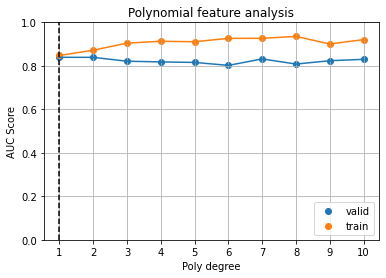

In [50]:
# Plot data
plt.scatter(poly_degrees, valid_auc_scores, label='valid')
plt.plot(poly_degrees, valid_auc_scores)
plt.scatter(poly_degrees, train_auc_scores, label='train')
plt.plot(poly_degrees, train_auc_scores)

# Plot best poly degree, based on AUC calculation over VALID subset
best_deg = poly_degrees[np.argmax(valid_auc_scores)]
plt.axvline(best_deg, color='black', linestyle='--')

# Make the plot nice
plt.xlabel('Poly degree')
plt.ylabel('AUC Score')
plt.ylim([0,1])
plt.xticks(poly_degrees)
plt.grid(b=True)
plt.legend()
plt.title('Polynomial feature analysis')
plt.show()

Ahora volvemos a probar lo mismo, esta vez desactivando el parámetro *interactions_only*. Aumento el grado de regularización dado que la cantidad de variables escala rápidamente con el orden del polinimio, produciendo overfitting.

In [51]:
%%time
valid_auc_scores = []
train_auc_scores = []

for deg in poly_degrees:
    
    # Create and initialize polynomial preprocessor
    poly = preprocessing.PolynomialFeatures(degree=deg, include_bias=False, interaction_only=False)
    poly.fit(x_train_un)
    
    # Get poly subsets, but unnormalized
    x_train_poly = poly.transform(x_train_un)
    x_valid_poly = poly.transform(x_valid_un)
    x_test_poly = poly.transform(x_test_un)
    
    # Apply z-score to normalize poly subsets

    # Create an instance of the StandardScaler for each variable
    scaler = preprocessing.StandardScaler()

    # Fit the distribution
    scaler.fit(x_train_poly)

    # Transform and normalize all variables
    x_train_poly = scaler.transform(x_train_poly)
    x_test_poly = scaler.transform(x_test_poly)
    x_valid_poly = scaler.transform(x_valid_poly)
    
    # Configuring TensorBoard to log learning process
    log_dir = "logs/fit/POLY/iodisabled" + str(deg)
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    # Define the Model Checkpoint callback.
    mc_path = 'model_checkpoints/get_best_poly_' + str(deg) + '_iodisabled_checkpoint.h5'
    mc_callback = ModelCheckpoint(filepath=mc_path, monitor='val_auc', save_best_only=True, mode='max')

    # Creating model
    p_model  = Sequential()
    p_model.add(Dense(1, input_shape=(poly.n_output_features_,), activation='sigmoid', use_bias=True, kernel_regularizer=l2(1e-2)))
    # Compiling model
    p_model.compile(optimizer=SGD(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=metrics)
    # Fitting model
    p_model.fit(x_train_poly, y_train, validation_data=(x_valid_poly, y_valid), shuffle=True, epochs=200, batch_size=32, verbose=0, callbacks=[es_callback, mc_callback, tensorboard_callback])
    
    # Load best model
    p_model = load_model(mc_path)
    
    # Inform number of variables in model
    input_n = x_train_poly.shape[1]
    
    # Evaluate model
    print(f'--- Polynomial order = {deg} ---')
    print(f'Input count = {input_n}') 
    eval_valid = p_model.evaluate(x=x_valid_poly, y=y_valid, return_dict=True, verbose=0)
    eval_train = p_model.evaluate(x=x_train_poly, y=y_train, return_dict=True, verbose=0)
    
    # Append scores to result
    auc_t = eval_train['auc']
    auc_v = eval_valid['auc']
    
    valid_auc_scores.append(auc_v)
    train_auc_scores.append(auc_t)
    print(f'AUC for TRAIN subset is {auc_t:.4f}')
    print(f'AUC for VALID subset is {auc_v:.4f}')

--- Polynomial order = 1 ---
Input count = 8
AUC for TRAIN subset is 0.8468
AUC for VALID subset is 0.8370
--- Polynomial order = 2 ---
Input count = 44
AUC for TRAIN subset is 0.8912
AUC for VALID subset is 0.8422
--- Polynomial order = 3 ---
Input count = 164
AUC for TRAIN subset is 0.9190
AUC for VALID subset is 0.8233
--- Polynomial order = 4 ---
Input count = 494
AUC for TRAIN subset is 0.9722
AUC for VALID subset is 0.8086
--- Polynomial order = 5 ---
Input count = 1286
AUC for TRAIN subset is 0.9792
AUC for VALID subset is 0.7821
--- Polynomial order = 6 ---
Input count = 3002
AUC for TRAIN subset is 0.9395
AUC for VALID subset is 0.7728
--- Polynomial order = 7 ---
Input count = 6434
AUC for TRAIN subset is 0.9379
AUC for VALID subset is 0.7705
--- Polynomial order = 8 ---
Input count = 12869
AUC for TRAIN subset is 0.9892
AUC for VALID subset is 0.7521
--- Polynomial order = 9 ---
Input count = 24309
AUC for TRAIN subset is 0.9384
AUC for VALID subset is 0.7482
--- Polynomial 

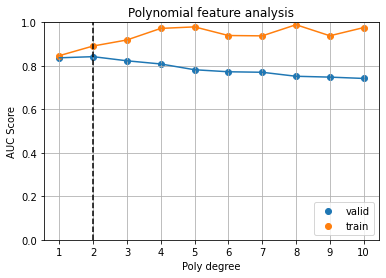

In [52]:
# Plot data
plt.scatter(poly_degrees, valid_auc_scores, label='valid')
plt.plot(poly_degrees, valid_auc_scores)
plt.scatter(poly_degrees, train_auc_scores, label='train')
plt.plot(poly_degrees, train_auc_scores)

# Plot best poly degree, based on AUC calculation over VALID subset
best_deg = poly_degrees[np.argmax(valid_auc_scores)]
plt.axvline(best_deg, color='black', linestyle='--')

# Make the plot nice
plt.xlabel('Poly degree')
plt.ylabel('AUC Score')
plt.ylim([0,1])
plt.xticks(poly_degrees)
plt.grid(b=True)
plt.legend()
plt.title('Polynomial feature analysis')
plt.show()

# 13. Agregando K-Folding

In [53]:
# Importing KFold from sklearn
from sklearn.model_selection import KFold

def kfold_crossval(model, x, y, metrics, n_splits=2, shuffle=False, random_state=None, epochs=1, verbose='auto', callbacks=None, batch_size=32):
    x = x.to_numpy()
    y = y.to_numpy()
    # Initialize kfold splitter
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    fold_num = 1
    
    # Create arrays for metrics
    auc_valid = []
    auc_train = []
    
    for train_index, valid_index in kf.split(x):
        print(f'----- Fold N = {fold_num} -----')
        # Get train and valid splits
        x_train, y_train = x[train_index], y[train_index]
        x_valid, y_valid = x[valid_index], y[valid_index]
        
        # Fit model
        history = model.fit(x=x_train, 
                  y=y_train, 
                  validation_data=(x_valid, y_valid), 
                  shuffle=shuffle, 
                  epochs=epochs, 
                  batch_size=batch_size, 
                  verbose=verbose, 
                  callbacks=callbacks
                 )
        
        # Get metrics
        eval_train = model.evaluate(x=x_train, y=y_train, return_dict=True, verbose=0)
        eval_valid = model.evaluate(x=x_valid, y=y_valid, return_dict=True, verbose=0)
        
        tscore = eval_train['auc']
        vscore = eval_valid['auc']
        
        tsize = x_train.shape[0]
        vsize = x_valid.shape[0]
        
        # Append metrics
        auc_train.append(tscore)
        auc_valid.append(vscore)
        
        print(f'Size for TRAIN is {tsize}')
        print(f'Size for VALID is {vsize}')
        
        print(f'AUC for TRAIN is {tscore:.4f}')
        print(f'AUC for VALID is {vscore:.4f}')
        
        # Increase fold number
        fold_num = fold_num + 1
        
    return auc_train, auc_valid

In [54]:
model = Sequential()
model.add(Dense(1, input_shape=(8,), activation='sigmoid', use_bias=True))
# Compiling model
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=metrics)
# Training model
auct, aucv = kfold_crossval(model=model, x=x_train, y=y_train, metrics=metrics,
                            n_splits=5, shuffle=False, random_state=None, epochs=1000, verbose=0, 
                            callbacks=[tensorboard_callback, es_callback, mc_callback])
#es_model.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), shuffle=True, epochs=1000, batch_size=32, verbose=1, callbacks=[tensorboard_callback, es_callback, mc_callback])

----- Fold N = 1 -----
Size for TRAIN is 343
Size for VALID is 86
AUC for TRAIN is 0.8084
AUC for VALID is 0.9301
----- Fold N = 2 -----
Size for TRAIN is 343
Size for VALID is 86
AUC for TRAIN is 0.8527
AUC for VALID is 0.7848
----- Fold N = 3 -----
Size for TRAIN is 343
Size for VALID is 86
AUC for TRAIN is 0.8422
AUC for VALID is 0.8177
----- Fold N = 4 -----
Size for TRAIN is 343
Size for VALID is 86
AUC for TRAIN is 0.8403
AUC for VALID is 0.8416
----- Fold N = 5 -----
Size for TRAIN is 344
Size for VALID is 85
AUC for TRAIN is 0.8464
AUC for VALID is 0.8222


In [55]:
aucv_mean = np.mean(aucv)
auct_mean = np.mean(auct)
print(f'Average AUC for TRAIN is {auct_mean:.4f}')
print(f'Average AUC for VALID is {aucv_mean:.4f}')

Average AUC for TRAIN is 0.8380
Average AUC for VALID is 0.8393
